In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import shutil

src_folder = '/content/drive/My Drive/[Subtitlist] naruto-season-1-english-2206507'
dst_folder = '/content/subtitles'

import os

if os.path.exists(dst_folder):
    print("Destination folder already exists.")
else:
    shutil.copytree(src_folder, dst_folder)



In [4]:
from glob import glob
subtitles_path=sorted(glob('/content/subtitles/*.ass'))

subtitles_path[:5]

['/content/subtitles/Naruto Season 1 - 01.ass',
 '/content/subtitles/Naruto Season 1 - 02.ass',
 '/content/subtitles/Naruto Season 1 - 03.ass',
 '/content/subtitles/Naruto Season 1 - 04.ass',
 '/content/subtitles/Naruto Season 1 - 05.ass']

In [5]:
scripts=[]
episode_num=[]
for path in subtitles_path:
  with open(path ,'r') as file:
    lines=file.readlines()
    lines=lines[27:]
    rows=[",".join(line.split(',')[9:]) for line in lines]

  rows=[line.replace("\\N",' ') for line in rows]
  script=" ".join(rows)

  episode=int(path.split('-')[1].split('.')[0].strip())

  scripts.append(script)
  episode_num.append(episode)


In [6]:
import pandas as pd
df = pd.DataFrame.from_dict({'episode':episode_num,'script':scripts})
df.head()

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   episode  218 non-null    int64 
 1   script   218 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.5+ KB


In [8]:
df.iloc[5]['script']

'C\'mon!\n Running like a fugitive,\n Being chased by something\n Inside my heart is pounding\n My throat dry like it\'s withering\n For no single one,\n To none does belong,\n This time is ours, right now...\n Unraveling the pain,\n Unraveling our hearts,\n Unraveling shadows\n Stifling our breath,\n Reaching for beyond,\n Tearing through the dark\n In fighting and in love\n To the distant light above,\n Yes, we are on the way\n I wanna rock...\n Rockin\' my heart\n Sasuke here at Point B!\n Sakura here at Point C!\n Naruto here. I\'m at Point A!\n You\'re slow, Naruto!\n Okay, the seventh squad…\n Hm?!\n The target has moved!\n Follow it!\n Alright! It\'s over there!\n What\'s your distance from the target?\n Five meters! I can go at anytime!\n I\'m ready, too!\n Me, too…!\n Okay…\n Do it!\n Uryaaah!\n I got him!\n Does he have the ribbon on his right ear…?\n Are you sure it\'s our target Tora?\n It\'s the target, no mistake.\n Alright, the mission to capture lost pet "Tora" is compl

In [9]:

import spacy

nlp=spacy.load('en_core_web_sm')

In [10]:
doc=nlp("Hardik went to Jaipur")
for ent in doc.ents:
  print(ent.text,ent.label_)

Hardik PERSON
Jaipur GPE


In [11]:
import nltk
from nltk import sent_tokenize

nltk.download('punkt')

def get_ners(script):
  script_sentences=sent_tokenize(script)
  ner_output=[]

  for sentence in script_sentences:
    doc=nlp(sentence)
    ners=set()
    for ent in doc.ents:
      if ent.label_=='PERSON':
        full_name=ent.text
        first_name=full_name.split(' ')[0]
        ners.add(first_name)

    ner_output.append(list(ners))
  return ner_output

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [12]:
df['ners']=df['script'].apply(get_ners)

In [13]:
window=10
entity_relationship=[]
for row in df['ners']:
  previous_entities_in_window=[]

  for sentence in row :
    previous_entities_in_window.append(sentence)
    previous_entities_in_window=previous_entities_in_window[-window:]

    previous_entities_flattened=sum(previous_entities_in_window, [])

    for entity in sentence:
      for entity_in_window in previous_entities_flattened:
        if entity!=entity_in_window:
          entity_rel=sorted([entity,entity_in_window])
          entity_relationship.append(entity_rel)


In [14]:
relationship_df=pd.DataFrame({'value':entity_relationship})

In [15]:
relationship_df['source']=relationship_df['value'].apply(lambda x:x[0])
relationship_df['target']=relationship_df['value'].apply(lambda x:x[1])

In [16]:
relationship_df=relationship_df.groupby(['source','target']).count().reset_index()

In [17]:
relationship_df=relationship_df.sort_values('value',ascending=False)
relationship_df.head()

,source,target,value
1506,Sakura,Sasuke,163
1097,Kakashi,Sasuke,131
727,Guy,Lee,93
544,Gaara,Lee,69
553,Gaara,Sasuke,67


In [18]:
relationship_df=relationship_df.head(200)

In [21]:
import networkx as nx
G=nx.from_pandas_edgelist(relationship_df,
                          source='source',
                          target='target',
                          edge_attr='value',
                          create_using=nx.Graph())

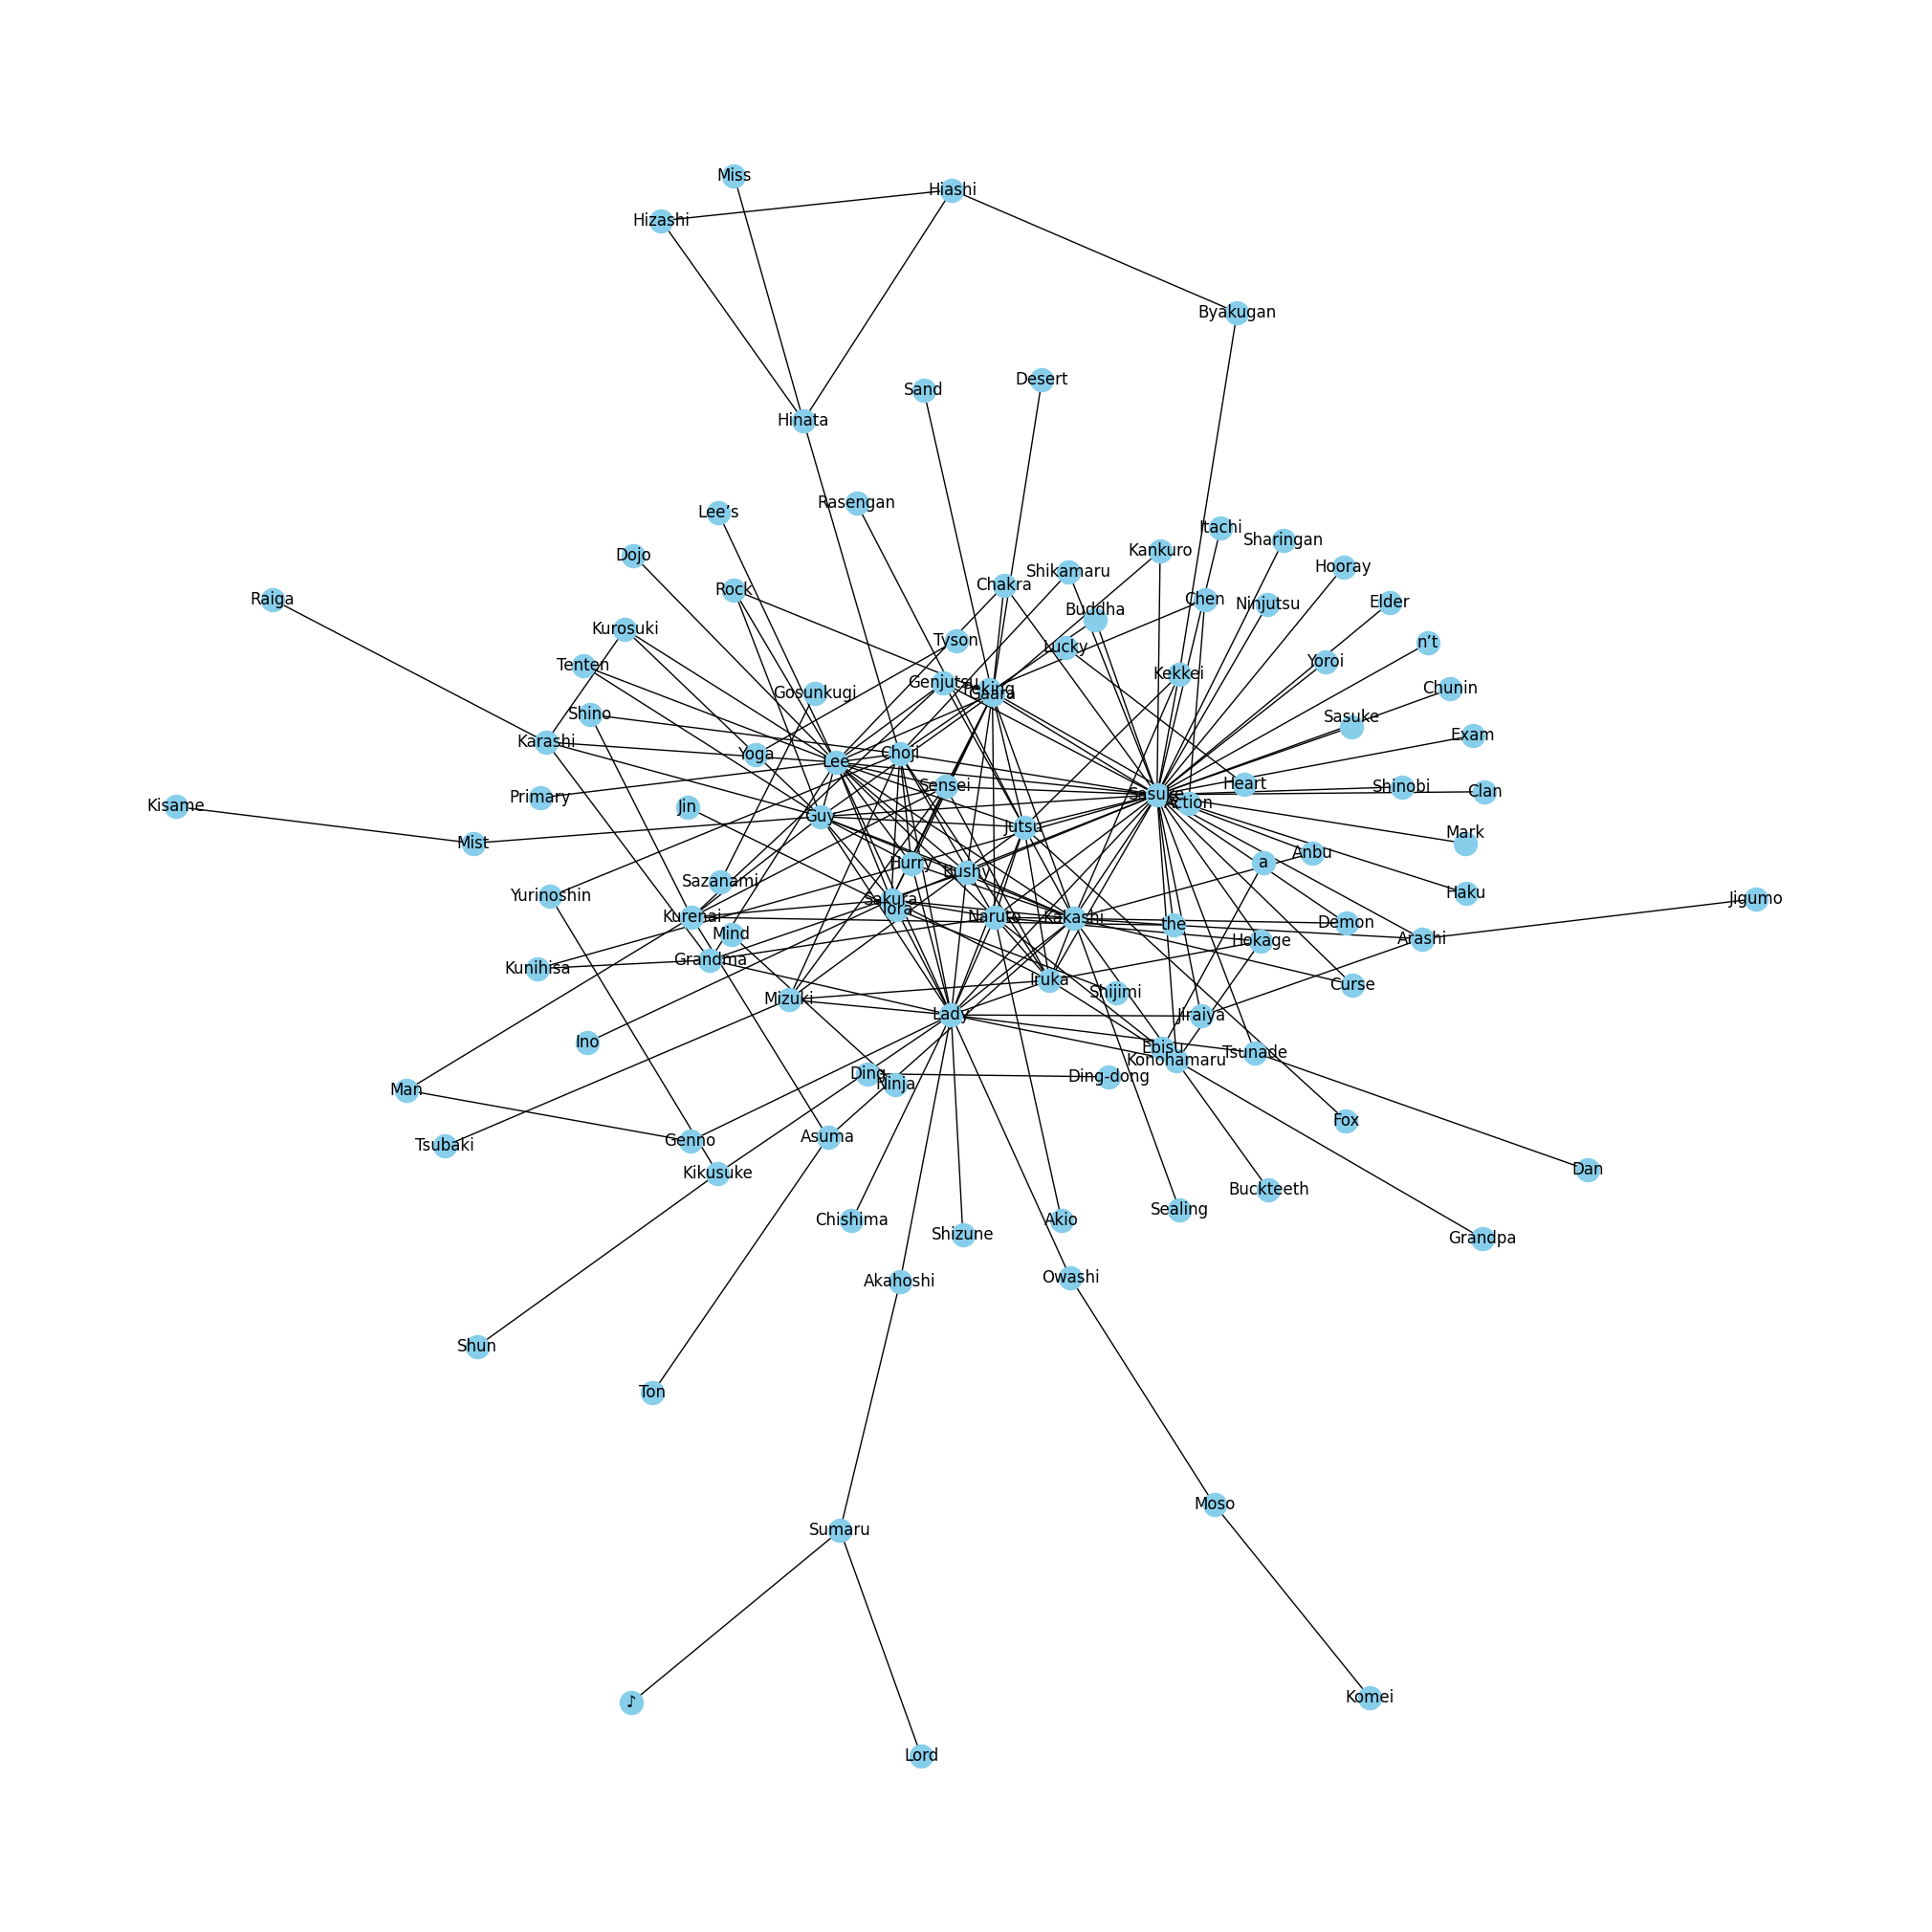

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
pos=nx.kamada_kawai_layout(G)
nx.draw(G,with_labels=True, node_color='skyblue',edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

In [27]:
# Install pyvis
!pip install pyvis

In [38]:


# Import necessary libraries
import networkx as nx
from pyvis.network import Network
from IPython.core.display import display, HTML

# Create a NetworkX graph with 200 nodes
G = nx.erdos_renyi_graph(80, 0.05)  # Adjust the number of nodes and probability as needed

# Initialize Pyvis network with cdn_resources set to 'in_line'
net = Network(notebook=True, width="1000px", height="700px", bgcolor='#222222', font_color='white', cdn_resources='in_line')

# Set node size based on degree (optional)
node_degree = dict(G.degree)
nx.set_node_attributes(G, node_degree, 'size')

# Add nodes and edges with labels to Pyvis network
for node in G.nodes:
    # Get the original label/name of the node (usually as a string or object)
    label = str(node)
    # Add node to Pyvis network with very small size
    net.add_node(node, label=label, size=5, color='skyblue')  # Adjust size as needed

for edge in G.edges:
    net.add_edge(edge[0], edge[1], color='blue')

# Save the visualization to an HTML file
net.show("network_visualization.html")

# Display the HTML file
display(HTML(filename="network_visualization.html"))


network_visualization.html
